In [1]:
import numpy as np
import pystan
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
%matplotlib inline

# Exercise 2: Rats

Thirty rats have their weight measured once per week shortly after being born, on days 8, 15, 22, 29, and 36. For this dataset, we are going to consider a prediction task: 

**Given the measurements on days 8, 15, and 22, can we predict the rat weight on days 29 and 36?**

As usual, the first thing to do is look at the data! We will subsample it here and plot just a few rows.

In [2]:
data = pd.read_csv("rats.csv");
print("Number of rows:", len(data))
data.head()

Number of rows: 30


,day8,day15,day22,day29,day36
0,151,199,246,283,320
1,145,199,249,293,354
2,147,214,263,312,328
3,155,200,237,272,297
4,135,188,230,280,323


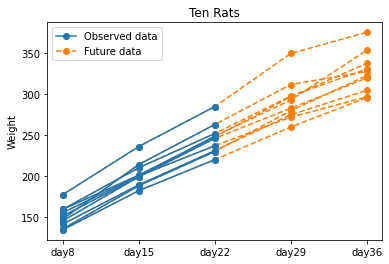

In [3]:
past_rats = data[['day8', 'day15', 'day22']]
future_rats = data[['day29', 'day36']]

# plot
f = plt.plot(data[:10].T, 'o--', c='C1');
p = plt.plot(past_rats[:10].T, 'o-', c='C0');
plt.legend([p[0], f[0]], ['Observed data', 'Future data']);
plt.ylabel("Weight");
plt.title("Ten Rats");

### Basic linear regression

The following Stan model implements a basic linear regression model: it estimates two coefficients, $\alpha$ and $\beta$, where $\alpha$ is the average weight of a rat at birth and $\beta$ is the average amount it grows in a week.

This model can be written as

$$\begin{align*}
y_{nt} \sim \mathcal{N}(\alpha + \beta x_t, \sigma_y^2)
\end{align*}$$

where $\sigma_y$ is observation noise, $x_t$ is the age of the rat in days at time $t$, and $y_{nt}$ is the weight of rat $n$ at time $t$.

Take note of both `for` loops used in the `model` and `generated quantities` blocks.

In [4]:
rats_model_code = """
data {
    int N; // number of rats    
    int T; // number of observed timesteps
    int x[T]; // date of measurement
    real y[N,T]; // matrix of weights by date

    int T_test; // number of held-out timesteps
    int x_test[T_test]; // dates of held-out timesteps
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma_y;
}
model {
    sigma_y ~ normal(0, 100); // prior on scale
    for (n in 1:N) {
        for (t in 1:T) {
            y[n,t] ~ normal(alpha + beta * x[t], sigma_y);
        }
    }
}
generated quantities {
    real y_hat[T_test];  // predictions into the future (mean)
    real y_pred[T_test]; // predictions into the future (sampled)
    
    for (t in 1:T_test) {
        y_hat[t] = alpha + beta * x_test[t]; // predictive mean
        y_pred[t] = normal_rng(y_hat[t], sigma_y); // sampled prediction
    }
}
"""
rats_model_basic = pystan.StanModel(model_code=rats_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5d48d1e577a16c5c9d9fdc1afa444f87 NOW.
/Users/brooks/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/p5/l7hjjt052zzf95mb4qqnb6nw0000gn/T/tmpeu5f9lxc/stanfit4anon_model_5d48d1e577a16c5c9d9fdc1afa444f87_5417757400512429388.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [5]:
rats_data = {'N': len(past_rats),
             'T': 3,
             'x': [8, 15, 22],
             'y': past_rats,
             'T_test': 2,
             'x_test': [29, 36]};

In [6]:
fit = rats_model_basic.sampling(data=rats_data, chains=4, iter=2000);
print(fit.stansummary(pars=['alpha', 'beta', 'sigma_y']));

Inference for Stan model: anon_model_5d48d1e577a16c5c9d9fdc1afa444f87.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   100.24     0.1    4.1  91.93  97.52  100.3 103.06 108.12   1628    1.0
beta      6.63  6.3e-3   0.25   6.14   6.46   6.62    6.8   7.14   1613    1.0
sigma_y  13.37    0.02   1.04  11.52  12.64   13.3  14.02   15.6   2012    1.0

Samples were drawn using NUTS at Sun Nov 29 21:22:26 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## Task: Model differences between rats

The predictions look fairly good. However, these predictions are the same *for every rat*. It doesn't account for the individual variation in rats at all.

Looking at the plot, we see that some rats are consistently heavier than others, or may grow at consistently faster or slower rates.

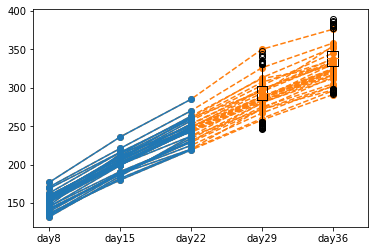

In [7]:
f = plt.plot(data.T, 'o--', c='C1');
p = plt.plot(past_rats.T, 'o-', c='C0');
plt.boxplot(fit['y_pred'], positions=(3, 4));
plt.xticks(np.arange(5), data.columns);

* **Q** How can we modify the model to capture differences in rats?

Think about how to modify the model, and write it here. In order to be compatible with the plotting scripts below, your model should have vectors of length $N$ for `alpha[N]` and `beta[N]`.

In [8]:
rats_model_code = """
data {
    int N; // number of rats    
    int T; // number of observed timesteps
    real x[T]; // date of measurement
    real y[N,T]; // matrix of weights by date
    
    int T_test; // number of held-out timesteps
    real x_test[T_test]; // dates of held-out timesteps
}
parameters {
    real alpha[N];
    real beta[N];
    real<lower=0> sigma_y;
    
    real mu_a;
    real mu_b;
    real<lower=0> tau_a;
    real<lower=0> tau_b;
}
model {
    // prior on scale
    tau_a ~ normal(0, 100);
    tau_b ~ normal(0, 100);
    sigma_y ~ normal(0, 100);
    
    // per-rat slope and intercept
    alpha ~ normal(mu_a, tau_a);
    beta ~ normal(mu_b, tau_b);
    
    // likelihood
    for (n in 1:N) {
        for (t in 1:T) {
            y[n,t] ~ normal(alpha[n] + beta[n] * x[t], sigma_y);
        }
    }
}
generated quantities {
    real y_hat[N,T_test]; 
    real y_pred[N,T_test];
    
    for (n in 1:N) {
        for (t in 1:T_test) {
            y_hat[n,t] = alpha[n] + beta[n] * x_test[t]; // predictive mean
            y_pred[n,t] = normal_rng(y_hat[n,t], sigma_y); // sampled prediction
        }
    }
}
"""
rats_model = pystan.StanModel(model_code=rats_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ae15aecf51ff1d99978b5400a7521042 NOW.
/Users/brooks/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/p5/l7hjjt052zzf95mb4qqnb6nw0000gn/T/tmpla3cg19k/stanfit4anon_model_ae15aecf51ff1d99978b5400a7521042_359040084876553653.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [9]:
fit = rats_model.sampling(data=rats_data, chains=4, iter=2000);
print(fit)

Inference for Stan model: anon_model_ae15aecf51ff1d99978b5400a7521042.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]      98.31    0.06    4.8  88.97  95.12  98.35 101.41 107.86   6995    1.0
alpha[2]      92.89    0.06   4.85  83.22  89.67  93.01  96.08 102.34   5990    1.0
alpha[3]      94.73    0.08    5.2  84.66  91.32  94.71  98.16 105.03   4548    1.0
alpha[4]     103.93    0.06    4.9  94.33 100.67 104.01 107.15 113.53   6421    1.0
alpha[5]      86.95    0.06   4.75  77.77  83.78  87.01  90.04  96.36   5586    1.0
alpha[6]     105.79    0.05   4.64  96.51 102.76 105.75 108.96 115.03   7902    1.0
alpha[7]      91.74    0.06   4.83  82.45  88.52  91.75  95.04 101.21   6358    1.0
alpha[8]     104.52    0.06   4.59  95.65 101.47 104.52 107.61 113.63   5951    1.0
alpha[9]     118.21    0.08   5.17 108.29 114.63 118.24

### Plot predictions for each rat

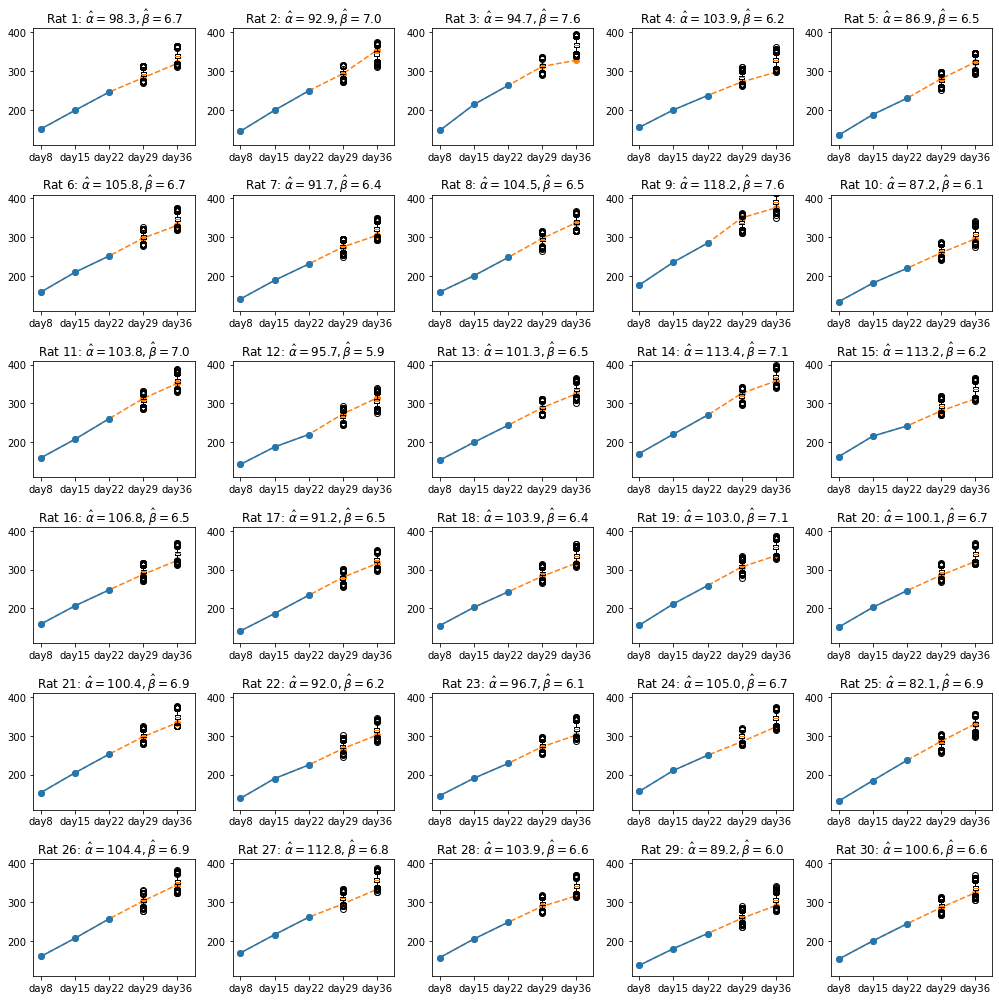

In [10]:
plt.figure(figsize=(14, 14));
for i in range(len(data)):
    plt.subplot(6, 5, i+1);
    plt.plot(data.loc[i], 'o--', c='C1');
    plt.plot(past_rats.loc[i], 'o-', c='C0');
    plt.boxplot(fit['y_pred'][:,i], positions=(3, 4));
    plt.xticks(np.arange(5), data.columns);
    plt.title('Rat %d: $\hat \\alpha = %0.1f, \hat \\beta = %0.1f$' % (i+1, fit['alpha'][:,i].mean(), fit['beta'][:,i].mean()))
    plt.ylim(110, 410);

plt.tight_layout();

## Task: Predicting weights for new rats

In the previous model, we supposed that for all 30 rats we only observed their weights at days 8, 15, and 22.

Sometimes we might have settings where we have collected complete data for a handful of rats, and are interested in making predictions on new rats.

Here, let's suppose a first experiment measured rats 1-25 for 36 days, and now in a second experiment we are measuring rats 26-30, currently just finishing day 22.

* **Q** What can we learn from having already collected data on 25 rats? Do we expect predictions for rats 26-30 to be the same as in the previous model?


In [11]:
new_rats_code = """
data {
    int N_obs; // number of fully observed rats
    int N_new; // number of new rats
    
    int T_obs; // number of timestamps for observed rats
    int T_new; // number of timestamps for new rats
    int T_test; // number of timestamps to predict for new rats
    
    int x_obs[T_obs]; // date of measurement
    real y_obs[N_obs,T_obs]; // matrix of weights by date

    int x_new[T_new]; // date of measurement
    real y_new[N_new,T_new]; // matrix of weights by date
    
    int x_test[T_test]; // dates of timestamps to predict
}
parameters {
    real alpha[N_obs + N_new];
    real beta[N_obs + N_new];
    real<lower=0> sigma_y;
    
    real mu_a;
    real mu_b;
    real<lower=0> tau_a;
    real<lower=0> tau_b;
}
model {
    // prior on scale
    tau_a ~ normal(0, 100);
    tau_b ~ normal(0, 100);
    sigma_y ~ normal(0, 100);
    
    // per-rat slope and intercept
    alpha ~ normal(mu_a, tau_a);
    beta ~ normal(mu_b, tau_b);
    
    // likelihood for fully-observed rats
    for (n in 1:N_obs) {
        for (t in 1:T_obs) {
            y_obs[n,t] ~ normal(alpha[n] + beta[n] * x_obs[t], sigma_y);
        }
    }
    
    // likelihood for partially-observed rats
    for (n in 1:N_new) {
        for (t in 1:T_new) {
            y_new[n,t] ~ normal(alpha[N_obs+n] + beta[N_obs+n] * x_new[t], sigma_y);
        }
    }
}
generated quantities {
    // just compute predictions for the new rats
    real y_hat[N_new,T_test]; 
    real y_pred[N_new,T_test];
    
    for (n in 1:N_new) {
        for (t in 1:(T_test)) {
            y_hat[n,t] = alpha[N_obs+n] + beta[N_obs+n] * x_test[t]; // predictive mean
            y_pred[n,t] = normal_rng(y_hat[n,t], sigma_y); // sampled prediction
        }
    }
}
"""
new_rats_model = pystan.StanModel(model_code=new_rats_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_46fc66e1db06f62777bc42168228e41f NOW.
/Users/brooks/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/p5/l7hjjt052zzf95mb4qqnb6nw0000gn/T/tmp419s5no9/stanfit4anon_model_46fc66e1db06f62777bc42168228e41f_6589064485184920587.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [12]:
initial_rats = data[:25]
new_past_rats = data[25:][['day8', 'day15', 'day22']]

split_rats_data = {'N_obs': len(initial_rats),
                   'N_new': len(new_past_rats),
                   'T_obs': 5,
                   'T_new': 3,
                   'T_test': 2,
                   'x_obs': [8, 15, 22, 29, 36],
                   'x_new': [8, 15, 22],
                   'x_test': [29, 36],
                   'y_obs': initial_rats,
                   'y_new': new_past_rats };


In [13]:
pred_fit = new_rats_model.sampling(data=split_rats_data, chains=4, iter=2000);
print(pred_fit.stansummary())

Inference for Stan model: anon_model_46fc66e1db06f62777bc42168228e41f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]     105.9    0.06   5.24  95.55 102.31 105.87 109.45 116.15   6963    1.0
alpha[2]     95.82    0.07   5.67  84.41  92.02  95.86  99.61 106.92   5752    1.0
alpha[3]    108.72    0.07   5.43  97.96 105.03 108.68 112.41 119.25   6572    1.0
alpha[4]    112.12    0.07   5.41 101.51 108.42 112.14 115.69 122.41   5753    1.0
alpha[5]     91.23    0.07   5.55  80.65  87.38  91.21  94.95 102.06   6635    1.0
alpha[6]    111.64    0.06   5.25 101.38 108.09 111.57 115.07 122.17   7247    1.0
alpha[7]     98.66    0.06   5.34  88.25  95.15  98.61 102.23 109.41   7723    1.0
alpha[8]    106.75    0.06   5.14  96.41 103.31 106.79 110.21 116.67   7444    1.0
alpha[9]    123.26    0.08   5.68 112.27 119.35 123.18 126.99  1

### Plot predictions on the five new rats

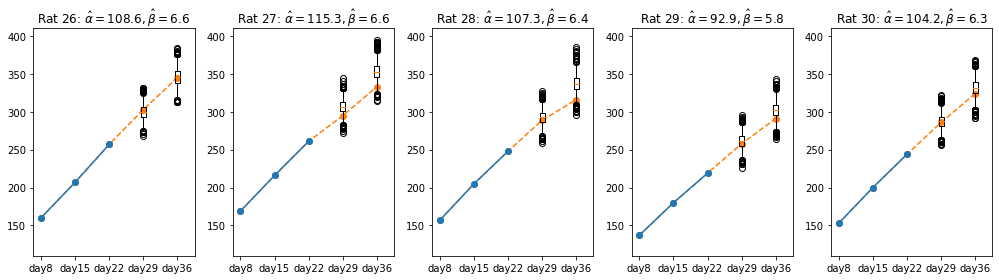

In [14]:
plt.figure(figsize=(14, 4));
for i in range(5):
    plt.subplot(1, 5, i+1);
    plt.plot(data.loc[25+i], 'o--', c='C1');
    plt.plot(new_past_rats.loc[25+i], 'o-', c='C0');
    plt.boxplot(pred_fit['y_pred'][:,i], positions=(3, 4));
    plt.xticks(np.arange(5), data.columns);
    plt.title('Rat %d: $\hat \\alpha = %0.1f, \hat \\beta = %0.1f$' % (i+26, pred_fit['alpha'][:,25+i].mean(), pred_fit['beta'][:,25+i].mean()))
    plt.ylim(110, 410);

plt.tight_layout();

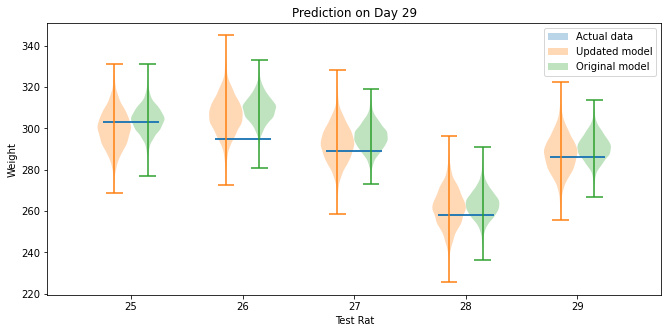

In [15]:
plt.figure(figsize=(11,5));
m0 = plt.violinplot(data[25:][['day29', 'day36']].to_numpy().T[:1,:], positions=np.arange(25,30), widths=1.0);
m1 = plt.violinplot(pred_fit['y_pred'][:,:,0], positions=np.arange(25,30)-0.15, widths=0.3);
m2 = plt.violinplot(fit['y_pred'][:,25:,0], positions=np.arange(25,30)+0.15, widths=0.3);
plt.title("Prediction on Day 29")
plt.xlabel("Test Rat")
plt.legend([m0['bodies'][0], m1['bodies'][0], m2['bodies'][0]], ["Actual data", "Updated model", "Original model"]);
plt.ylabel("Weight");

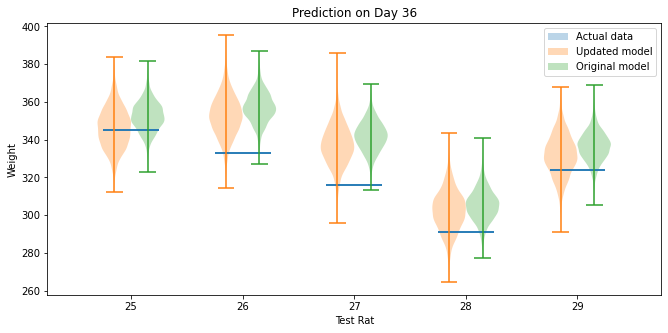

In [16]:
plt.figure(figsize=(11,5));
m0 = plt.violinplot(data[25:][['day29', 'day36']].to_numpy().T[1:,:], positions=np.arange(25,30), widths=1.0);
m1 = plt.violinplot(pred_fit['y_pred'][:,:,1], positions=np.arange(25,30)-0.15, widths=0.3);
m2 = plt.violinplot(fit['y_pred'][:,25:,1], positions=np.arange(25,30)+0.15, widths=0.3);
plt.title("Prediction on Day 36")
plt.xlabel("Test Rat")
plt.legend([m0['bodies'][0], m1['bodies'][0], m2['bodies'][0]], ["Actual data", "Updated model", "Original model"]);
plt.ylabel("Weight");

* **Q** How do the predictions change? Do these results make sense? 
* **Q** Is this a better fit on these last five rats than the original model, which never saw any measurements at days 29 or 36? Why or why not?
* **Q** What does this imply, if anything, about our choice of linear model.

## Task: Improving the predictive model

Plot the alphas and betas for both these models, for the last five rats. What can we learn from these?

One possibility is that the assumption of our model, that rat weight increases linearly over time, is unrealistic. An advantage of probabilistic programming is it makes it easy to iterate on modeling choices. Try replacing the predictive mean with another function (possibly nonlinear) and see if you can make an improvement. 
